In [1]:
from model import atp_graph, atp_pipeline
from data_wrangler import synthetic_data_gen, feature_extractor
import keras
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import tensorflow as tf
import IPython
import time
import os

In [2]:
t, Y = synthetic_data_gen.GP_functions_gen(samples=200)

In [1]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ExpSineSquared, WhiteKernel, RBF, Matern, RationalQuadratic



In [4]:
seq_len=100
samples = 1000
noise=False

In [5]:
kernel = RBF()
gp = GaussianProcessRegressor(kernel=kernel)
t = np.random.uniform(-2, 2,(samples, seq_len))

# GP(0, RBF(1))
Z_t = np.array([gp.sample_y(t[i, :].reshape(-1, 1), 1) for i in range(samples)])

ϵ_t = 0
# indep. noise
if noise:
    ϵ_t = np.random.normal(0, 0.1, (samples,T//2, 1))

## Probability model
Y_t = Z_t + ϵ_t

In [ ]:
samples = 10000
T= 100
k = gpflow.kernels.RBF() 
k1 = gpflow.kernels.RBF(0.6) 

t = np.concatenate([np.linspace(5,15,T//2), np.linspace(5,15,T//2)])
e = np.concatenate((np.zeros((T//2, 1)),np.ones((T//2, 1)))).reshape(-1, 1) 


# GP(0, RBF(1))
Z_t = np.random.multivariate_normal(np.zeros(100), k(t.reshape(-1, 1)), samples)

# constant shift
G_k = np.random.multivariate_normal(np.zeros(100), k1(t.reshape(-1, 1)), samples)

e2 = np.concatenate((np.zeros((T//2, 1)), np.ones((T//2, 1)))).reshape(-1, 1) 

# indep. noise
# ϵ_t_e = np.random.normal(0, 0.05, (100, samples))

## Probability model
y_t_e = (Z_t.transpose()) + e2.reshape(-1, 1) * (G_k.transpose())  #+ ϵ_t_e

In [3]:
def batcher(t, y, idx_list,batch_s = 32, window = 288,cut_sequence = True):
    '''
    cutting one long array to sequences of length 'window'.
    'batch_s' must be ≤ full array - window length
    '''
    
    
    if len(idx_list) < 1:
        print("warning- you didn't loop over the correct range")
        
    
    batch_s = min(batch_s, y.shape[0]-window)    
    idx = np.random.choice(len(idx_list), batch_s, replace = False)

    y = np.array([np.array(y)[idx_list[i]:idx_list[i]+window, :, :] for i in idx])
    t = np.array([np.array(t)[idx_list[i]:idx_list[i]+window, :, :] for i in idx])
    for i in sorted(idx, reverse=True): del idx_list[i]
    return t, y,idx_list

In [4]:
t.shape

(200, 100)

In [5]:
a,b,c = batcher(t[:, :, np.newaxis], Y, list(range(Y.shape[0])), window=1)

In [6]:
Y.shape

(200, 100, 1)

In [7]:
t[:, :, np.newaxis].shape

(200, 100, 1)

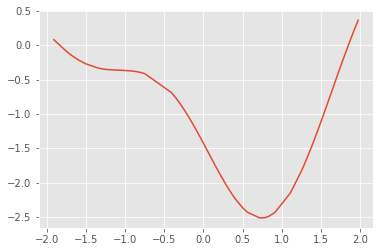

In [8]:
plt.plot(np.sort(t[0, :]), Y[0, np.argsort(t[0, :]), 0])
plt.show()

In [31]:
save_dir = "/Users/omernivron/Downloads/ATP_weights/RBF/"

#### Setup parameters

In [33]:
tf.random.set_seed(442)
opt = tf.keras.optimizers.Adam(3e-4)
run=2; heads=2
atp_model = atp_pipeline.atp_pipeline(num_heads=4, projection_shape_for_head=4, output_shape=64, rate=0.1, permutation_repeats=1,
                 bound_std=False, num_layers=3, enc_dim=32, xmin=0.1, xmax=2)

EPOCHS = 40; seq_l = Y.shape[1];
num_batches = 500
batch_s=20
mini = 50000
n_C_te =5

In [42]:
step = 1
tr_step = atp_graph.build_graph()

name_comp = 'run_' + str(run)
logdir = save_dir + '/logs/' + name_comp
folder = save_dir + '/ckpt/check_' + name_comp

if not os.path.exists(folder): os.mkdir(folder)
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=opt, net=atp_model)
manager = tf.train.CheckpointManager(ckpt, folder, max_to_keep=3)
ckpt.restore(manager.latest_checkpoint)

#### Training

In [43]:
Y.shape

(200, 100, 1)

In [44]:
t_tr.shape

(20, 100, 1)

In [45]:
if __name__ == '__main__':
    for epoch in range(EPOCHS):
        start = time.time()
        for batch_n in range(num_batches):

            n_C = 30
            n_T  = 70
            tr_ix = np.random.choice(np.arange(0, int(0.9 * Y.shape[0])), batch_s)
            y_tr = Y[tr_ix, :, :]
            t_tr = t[tr_ix, :, np.newaxis]

            μ, nll_pp, msex = tr_step(atp_model, opt, t_tr, y_tr, n_C, n_T, True )

            if ((batch_n % 100 == 0)):
                te_ix = np.random.choice(np.arange(int(0.9 * Y.shape[0]), Y.shape[0]), batch_s)
                y_te = Y[te_ix, :]
                t_te = t[te_ix, :]
                
                query_x, key_x, value_x, query_xy, key_xy, value_xy, mask, y_n = feature_extractor.make_features(t_te, y_te.squeeze(), n_C_te, batch_s=batch_s)
                μ_te, log_σ = atp_model(query_x, key_x, value_x, query_xy, key_xy, value_xy, mask, y_n)
                _,_,_, nll_pp_te, msex_te = losses.nll(y_te[:, n_C:n_C+n_T], μ_te, log_σ)

            if nll_pp_te < mini:
                mini = nll_pp_te
                IPython.display.clear_output(wait=True)
                print("epoch {} batch {} test lik pp: {}".format(epoch, batch_n, nll_pp)) 
                manager.save()
                step += 1
                ckpt.step.assign_add(1)
        print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

(20, None, 1)
(20, None, 1)
(20, 30, None, 1)
(20, 30, None, 1)


TypeError: in user code:

    File "/Users/omernivron/Documents/ATP/model/atp_graph.py", line 13, in train_step  *
        μ, log_σ = atp_model([x, y, n_C, n_T, training])
    File "/Users/omernivron/miniforge3/envs/tf_m1_n/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
        raise e.with_traceback(filtered_tb) from None

    TypeError: Exception encountered when calling layer "atp_pipeline_1" (type atp_pipeline).
    
    in user code:
    
        File "/Users/omernivron/Documents/ATP/model/atp_pipeline.py", line 63, in call  *
            y_diff, x_diff, d, x_n, y_n = self._DE([y, x, n_C, n_T, training])
        File "/Users/omernivron/miniforge3/envs/tf_m1_n/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
    
        TypeError: Exception encountered when calling layer "de" (type DE).
        
        in user code:
        
            File "/Users/omernivron/Documents/ATP/data_wrangler/feature_extractor.py", line 80, in call  *
                y_diff,  x_diff,  d,  x_n,  y_n = self.derivative_function([y,  x,  n_C,  n_T])
            File "/Users/omernivron/Documents/ATP/data_wrangler/feature_extractor.py", line 166, in derivative_function  *
                ix = tf.argsort(tf.cast(tf.math.reduce_euclidean_norm((current_x - x_temp),
        
            TypeError: Input 'y' of 'AddV2' Op has type int32 that does not match type float32 of argument 'x'.
        
        
        Call arguments received:
          • inputs=['tf.Tensor(shape=(20, None, 1), dtype=float32)', 'tf.Tensor(shape=(20, None, 1), dtype=float32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=bool)']
    
    
    Call arguments received:
      • inputs=['tf.Tensor(shape=(20, 100, 1), dtype=float32)', 'tf.Tensor(shape=(20, 100, 1), dtype=float32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=bool)']


### Inference

In [ ]:
t, y = batcher(client_300["t"][k:], client_300["300"][k:], batch_s=batch_s)
t, y, c, n = batch_sampler(t, y)

num_samples = 5
samples = []
for sample in range(num_samples):
    y_copy = np.copy(y[0, :])[np.newaxis, :]
    for i in range(int(c), int(c+n)):
        query_x, key_x, value_x, query_xy, key_xy, value_xy, mask, y_n = make_features(t[0, :][np.newaxis, :], y_copy, i, batch_s=1)
        crep = np.repeat(c, 1*(int(n)+int(c))).reshape(1, int(n)+int(c), 1)
        ŷ = atp((query_x, key_x, value_x, query_xy, key_xy, value_xy, mask, y_n[:, :, np.newaxis], crep), training=False)
        current_y = np.random.normal(ŷ[:, i, 0], np.exp(ŷ[:, i, 1]) + 0.001)
        y_copy[:, i] = current_y
    samples.append(y_copy)

In [ ]:
# plan: 
### hypo. : GP will do better on MHA-X alone as oppsed to MHA-XY alone 


In [12]:
import gpflow

In [520]:
t = np.tile(np.linspace(5,15,50), sum(num_per_model) + 1).reshape(-1, 1)

In [522]:
t[0:51, :]

array([[ 5.        ],
       [ 5.20408163],
       [ 5.40816327],
       [ 5.6122449 ],
       [ 5.81632653],
       [ 6.02040816],
       [ 6.2244898 ],
       [ 6.42857143],
       [ 6.63265306],
       [ 6.83673469],
       [ 7.04081633],
       [ 7.24489796],
       [ 7.44897959],
       [ 7.65306122],
       [ 7.85714286],
       [ 8.06122449],
       [ 8.26530612],
       [ 8.46938776],
       [ 8.67346939],
       [ 8.87755102],
       [ 9.08163265],
       [ 9.28571429],
       [ 9.48979592],
       [ 9.69387755],
       [ 9.89795918],
       [10.10204082],
       [10.30612245],
       [10.51020408],
       [10.71428571],
       [10.91836735],
       [11.12244898],
       [11.32653061],
       [11.53061224],
       [11.73469388],
       [11.93877551],
       [12.14285714],
       [12.34693878],
       [12.55102041],
       [12.75510204],
       [12.95918367],
       [13.16326531],
       [13.36734694],
       [13.57142857],
       [13.7755102 ],
       [13.97959184],
       [14

In [626]:
def RBF_gen_data(samples, num_models, error):
    T= 50 
    k = gpflow.kernels.RBF() 

    t = np.tile(np.linspace(5,15,T), (num_models) + 1).reshape(-1, 1)
    print(t.shape)

    e = {}
    for i in range(num_models):
        e[(i)] = np.zeros((len(t), 1))
        e[(i)][int(i*T):int(i+1)*T, :] = 1
    # e1 = np.concatenate([np.zeros((T//4, 1)),np.ones((T//4, 1)), np.zeros((T//4, 1)), np.zeros((T//4, 1))]).reshape(-1, 1) 
    # e2 = np.concatenate([np.zeros((T//4, 1)),np.zeros((T//4, 1)), np.ones((T//4, 1)), np.zeros((T//4, 1))]).reshape(-1, 1) 
    # e3 = np.concatenate([np.zeros((T//4, 1)),np.zeros((T//4, 1)), np.zeros((T//4, 1)), np.ones((T//4, 1))]).reshape(-1, 1) 
    # e4 = np.concatenate([np.ones((T//4, 1)),np.zeros((T//4, 1)), np.zeros((T//4, 1)), np.zeros((T//4, 1))]).reshape(-1, 1)


    # GP(0, RBF(1))
    print(t[:50].reshape(-1, 1).shape)
    print((len(t) // (num_models + 1)))
    Z_t = np.random.multivariate_normal(np.zeros((len(t))), k(t.reshape(-1, 1)), samples)
    print('Z_t: ', Z_t.shape)

    # constant shift
    # G_k = np.random.multivariate_normal(np.zeros(T), k1(t.reshape(-1, 1)), samples)
    G_k = np.random.normal(0, 1.3, size=num_models)
    G_k_o = np.random.normal(0, 0.5, size=1)
    G_k = np.concatenate([G_k, G_k_o])
    # G_k = np.repeat(G_k, T).reshape(1, -1)
    print(G_k.shape)

    # e2 = np.concatenate((np.zeros((T//2, 1)), np.ones((T//2, 1)))).reshape(-1, 1) 

    # indep. noise
    ϵ_t = {}
    for i in range(num_models):
        ϵ_t[i] = np.random.normal(0, error[i], (len(t) // (num_models + 1), samples))
        print(ϵ_t[i].shape)
    # ϵ_t_1 = np.random.normal(0, error[], (len(t), samples))
    # ϵ_t_2 = np.random.normal(0, 0.08, (len(t), samples))
    # ϵ_t_3 = np.random.normal(0, 0.17, (len(t), samples))
    # ϵ_t_4 = np.random.normal(0, 0.02, (T, samples))

    # Add climate change


    ## Probability model
    y_t_e = np.zeros((samples, len(t)))
    m = len(t)//(num_models + 1)
    for i in range(num_models):
        if (i==(num_models-1)):
            y_t_e[:, (m * i): m*(i+1)] =  ((Z_t.transpose()[(m * i): m*(i+1), :]) + (G_k[-1])).T
        else:
            y_t_e[:, (m * i): m*(i+1)] =  ((Z_t.transpose()[(m * i): m*(i+1), :]) + (G_k[i] + ϵ_t[i])).T


    # y_t_e = (Z_t.transpose()) + e1.reshape(-1, 1) * (G_k.transpose() + ϵ_t_1) + e2.reshape(-1, 1) * (G_k.transpose() + ϵ_t_2) + e3.reshape(-1, 1) * (G_k.transpose() + ϵ_t_3) +e4.reshape(-1, 1) * (G_k.transpose()) + (0.8 * ((t-5)/10)**2).reshape(-1, 1) #+ ϵ_t_e
    return t, y_t_e , Z_t#, G_k, e1, e2, e3, e4, ϵ_t_1, ϵ_t_2, ϵ_t_3

In [639]:
t, y_t_e, z = RBF_gen_data(100, 4, np.repeat(0.1, 20))

(250, 1)
(50, 1)
50
Z_t:  (100, 250)
(5,)
(50, 100)
(50, 100)
(50, 100)
(50, 100)


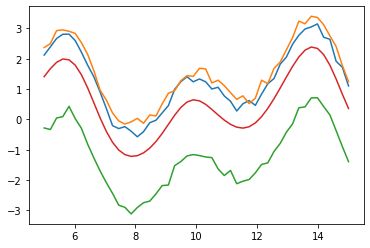

In [641]:
for i in range(4):
    plt.plot(t[:50], y_t_e[0, 50 * i:50*(i+1)])
    if i == 19:
        plt.plot(t[:50], y_t_e[0, 50 * i:50*(i+1)], c= 'r')



In [ ]:
# RBF entery 
def RBF_cov(t, t1):
    return np.exp(-0.5 * (t - t1)**2)

In [512]:
t.shape

(200,)

In [ ]:
def calc_cond_dist_RBF(num_obs, num_models, num_per_model):
    np.random.seed(42)

    # choose num observations
    # num_models
    num_per_model = np.repeat(num_per_model, num_models)
    error = np.random.normal(0, 0.1, num_models)
    # choose num per model 1
    # num_per_model_1 = 2
    # choose num per model 2
    # num_per_model_2 = 10

    t, y_t_e = RBF_gen_data(100, num_models, error)
    t = np.repeat(t[:num_obs], sum(num_per_model) + num_obs).reshape(-1, 1)
    
    m = [y_t_e[i*T//num_models:((i+1)*T//num_models), :num_per_model[i]] for i in range(num_per_model)]

    # init cov matrix
    cov_matrix = np.zeros((num_obs + sum(num_per_model), num_obs + sum(num_per_model)))

    # fill in cov matrix
    for i in range(num_obs):
        for j in range(num_obs):
            cov_matrix[i, j] = RBF_cov(t[i], t[j]) + .5 + (0.8 * ((t[i]-5)/10)**2)  # obs with obs
            if i == j:
                cov_matrix[i, j] += 0.0001
    # observations with models
    for k in range(num_models):
        for i in range(num_obs):
            for j in range(num_per_model[k]):
                cov_matrix[i, (k+1) * num_obs + j] = RBF_cov(t[i], t[num_obs + j])  +  (0.8 * ((t[i]-5)/10)**2)
    # model with itself
    for k in range(num_models):
        for i in range(num_per_model[k]):
            for j in range(num_per_model[k]):
                cov_matrix[(k+1) * num_obs + i, (k+1) * num_obs + j] = RBF_cov(t[(k+1) *num_obs + i], t[(k+1) *num_obs + j]) +  (0.8 * ((t[(k+1) *num_obs + i]-5)/10)**2) + 1.3 
                if i == j:
                    cov_matrix[(k+1) * num_obs + i, (k+1) * num_obs + j] += error[k]
    
    # model k with model j
    for k in range(num_models):
        for j in range(num_models):
            if j > k:
                for i in range(num_per_model[k]):
                    for l in range(num_per_model[j]):
                        cov_matrix[(k+1) * num_obs + i, (j+1) * num_obs + l] = RBF_cov(t[(k+1) *num_obs + i], t[(j+1) *num_obs + l]) +  (0.8 * ((t[(k+1) *num_obs + i]-5)/10)**2) 

    # # cov_matrix[:num_obs, :num_obs] = .5 + .5 + np.eye(num_obs)*0.001 # obs with obs
    # # cov_matrix[:num_obs, num_obs:] = .5 # obs with models
    # for i in range(len(num_per_model)):
    #     cov_matrix[num_obs + sum(num_per_model[:i]):num_obs + sum(num_per_model[:i+1]), num_obs:] = .5 # model i with models (bigger than i)
    #     cov_matrix[num_obs + sum(num_per_model[:i]):num_obs + sum(num_per_model[:i+1]), num_obs + sum(num_per_model[:i]):num_obs + sum(num_per_model[:i+1])] = (sigma_e[i])*np.eye(num_per_model[0]) + .5 + .5  # model i with model i 
    #     cov_matrix[num_obs + sum(num_per_model[:i]):num_obs + sum(num_per_model[:i+1]), :num_obs] = .5 # model i with obs

    # get conditional mean and variance
    # μa|b = μa + ΣabΣbb^{-1} (xb − μb) (2.81)
    # Σa|b = Σaa − ΣabΣbb^{-1} Σba. (2.82)
    # conditional_mu = 0 + np.matmul(cov_matrix[0, 1:1+sum(num_per_model)].reshape(1, -1), np.matmul(np.linalg.inv(cov_matrix[1:1+sum(num_per_model), 1:1+sum(num_per_model)]), y[num_obs:].reshape(-1, 1)))
    # conditional_sigma = cov_matrix[0, 0] - np.matmul(cov_matrix[0, 1:1+sum(num_per_model)].reshape(1, -1) , np.matmul(np.linalg.inv(cov_matrix[1:1+sum(num_per_model), 1:1+sum(num_per_model)]), cov_matrix[1:1+sum(num_per_model), 0].reshape(-1, 1)))
    #return # conditional_mu, conditional_sigma

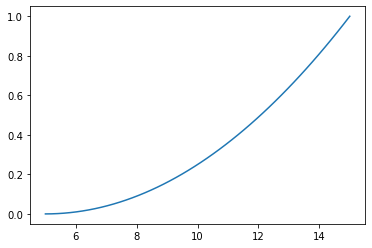

In [471]:
plt.plot(t[:T//4] , (((t-5)/10)**2).reshape(-1, 1)[:50, 0])

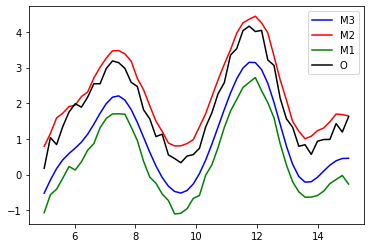

In [462]:
plt.plot(t[:T//4], y_t_e[ :T//4, 0], label="M3", color="blue")
plt.plot(t[T//4:T//2], y_t_e[T//4:T//2, 0], label="M2", color="red")
plt.plot(t[T//2:(3*T//4)], y_t_e[T//2:(3*T//4), 0], label="M1", color="green")
plt.plot(t[(3*T//4):], y_t_e[(3*T//4):, 0], label="O", color="black")

plt.legend()
plt.show()

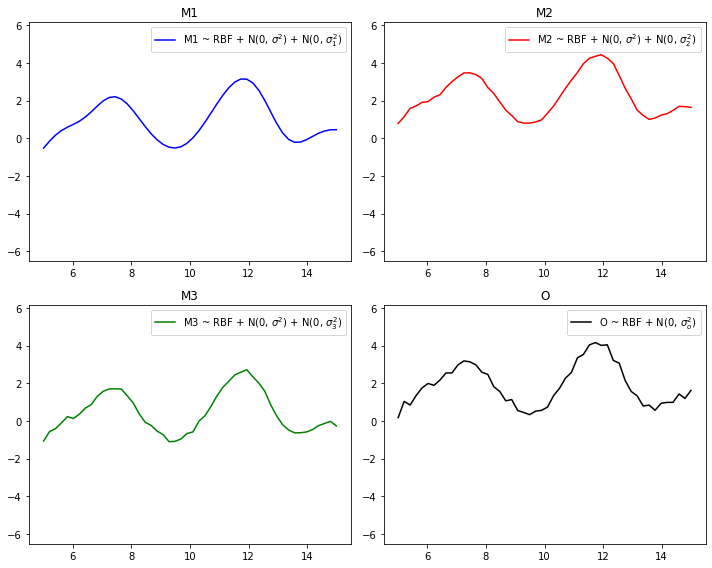

In [463]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming t and y_t_e are already defined in your context
# Here's a general structure based on the provided information

# # Sample data for demonstration (replace these with your actual data)
# T = 100
# t = np.linspace(0, 10, T)
# y_t_e = np.random.rand(T, 1)  # Sample data
global_min = np.min(y_t_e)
global_max = np.max(y_t_e)
# Creating subplots with 2 rows and 2 columns
labels = [
    "M1 ~ RBF + N(0, $\sigma^2$) + N(0, $\sigma_1^2$)",
    "M2 ~ RBF + N(0, $\sigma^2$) + N(0, $\sigma_2^2$)",
    "M3 ~ RBF + N(0, $\sigma^2$) + N(0, $\sigma_3^2$)",
    "O ~ RBF + N(0, $\sigma_o^2$)"
]

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plotting in individual subplots
axs[0, 0].plot(t[:T//4], y_t_e[:T//4, 0], label=labels[0], color="blue")
axs[0, 0].set_title('M1')
axs[0, 0].legend()
axs[0, 0].set_ylim(global_min, global_max)


axs[0, 1].plot(t[T//4:T//2], y_t_e[T//4:T//2, 0], label=labels[1], color="red")
axs[0, 1].set_title('M2')
axs[0, 1].legend()
axs[0, 1].set_ylim(global_min, global_max)

axs[1, 0].plot(t[T//2:(3*T//4)], y_t_e[T//2:(3*T//4), 0], label=labels[2], color="green")
axs[1, 0].set_title('M3')
axs[1, 0].legend()
axs[1, 0].set_ylim(global_min, global_max)

axs[1, 1].plot(t[(3*T//4):], y_t_e[(3*T//4):, 0], label=labels[3], color="black")
axs[1, 1].set_title('O')
axs[1, 1].legend()
axs[1, 1].set_ylim(global_min, global_max)

# Adjust layout for a better look
plt.tight_layout()
plt.show()


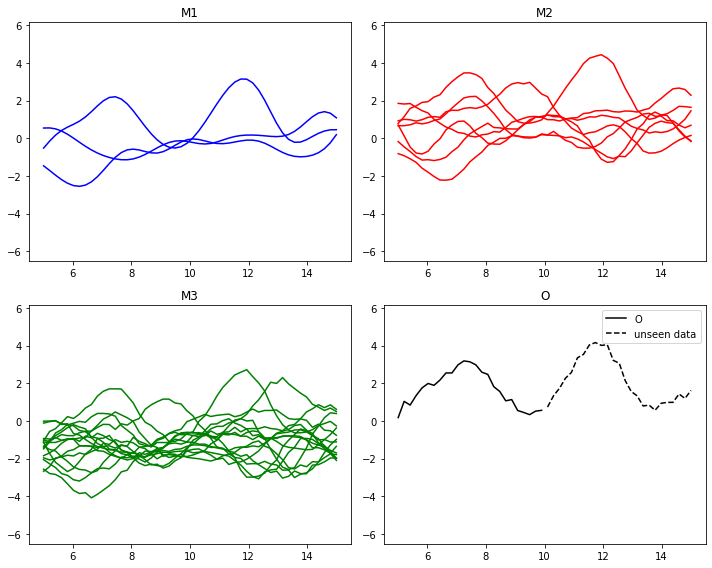

In [511]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming t and y_t_e are already defined in your context
# Here's a general structure based on the provided information

# # Sample data for demonstration (replace these with your actual data)
# T = 100
# t = np.linspace(0, 10, T)
# y_t_e = np.random.rand(T, 1)  # Sample data
global_min = np.min(y_t_e)
global_max = np.max(y_t_e)
# Creating subplots with 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plotting in individual subplots
axs[0, 0].plot(t[:T//4], y_t_e[:T//4, :3], label="M3", color="blue")
axs[0, 0].set_title('M1')
# axs[0, 0].legend()
axs[0, 0].set_ylim(global_min, global_max)


axs[0, 1].plot(t[T//4:T//2], y_t_e[T//4:T//2, :7], label="M2", color="red")
axs[0, 1].set_title('M2')
# axs[0, 1].legend()
axs[0, 1].set_ylim(global_min, global_max)

axs[1, 0].plot(t[T//2:(3*T//4)], y_t_e[T//2:(3*T//4), :15], label="M1", color="green")
axs[1, 0].set_title('M3')
# axs[1, 0].legend()
axs[1, 0].set_ylim(global_min, global_max)

axs[1, 1].plot(t[(3*T//4):int(3.5*T//4)], y_t_e[(3*T//4):int(3.5*T//4), 0], label="O", color="black")
axs[1, 1].plot(t[int(3.5*T//4):], y_t_e[int(3.5*T//4):, 0], linestyle = 'dashed', color="black", label="unseen data")
axs[1, 1].set_title('O')
axs[1, 1].legend()
axs[1, 1].set_ylim(global_min, global_max)

# Adjust layout for a better look
plt.tight_layout()
plt.show()


175.0

In [ ]:

An example demonstrates best how a probability model can be used to estimate internal variability.
Consider the following toy construction (disregarding time): random variable 𝐴 ∼ Normal(𝜇𝑎, 𝜎2
𝑎)
will represent the ’shared physics’ between real world observations and climate models. ’Real world
observations’ will be biased from the ’shared physics’ by random variable 𝑂 ∼ Normal(𝜇𝑜, 𝜎2
𝑜 ) and
each ’climate model’ 𝑖 will be biased by a random variable 𝑀𝑖 ∼ Normal(0, 𝜎2
𝑖 ). We can sample
from ’climate model’ 𝑖 by sampling from 𝐴 + 𝑀𝑖 . Each sample with addition of some noise 𝐸𝑖 𝑗 ∼
Normal(0, 𝜎2
e ) can play the role of ’initial condition run 𝑗’ in climate models. The ’internal variability’
we would like to learn is 𝜎2
𝑎 + 𝜎2
𝑜 (sum of Normal random variables), but from ’real world observations’
(𝐴 + 𝑂) 

In [313]:
def gen_data(num_obs, num_per_model):
    A = np.random.normal(7, .5, 1 + len(num_per_model))
    O = np.random.normal(0, .5, num_obs)
    sigma_e = np.random.uniform(0, 0.1, len(num_per_model))    
    E = [np.random.normal(0, sigma_e[i], num_per_model[i]) for i in range(len(num_per_model))]
    M = [np.random.normal(0, 0.5, num_per_model[i]) for i in range(len(num_per_model))] 
    # M3 = np.random.normal(0, 1, 1) + A + E3
    y = np.zeros((num_obs + sum(num_per_model)))
    y[:num_obs] = A[0] + O
    for i in range(len(num_per_model)):
        y[num_obs + sum(num_per_model[:i]):num_obs + sum(num_per_model[:i+1])] = A[i+1] + M[i] + E[i]
    return y, sigma_e, A, O, M, E




In [389]:
A.shape

(1000, 1)

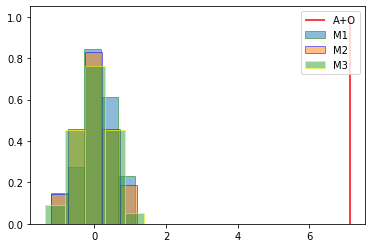

In [398]:
# plt.hist(A, label="A", alpha=0.5, density=True,edgecolor='black', bins=5)
# plt.hist(O, label="O", alpha=0.5)
plt.vlines(A[0] + O, 0, 1, label="A+O", color="red")
plt.hist(M[0], label="M1",    alpha=0.5, density=True, edgecolor='green', bins=5)
plt.hist(M[1], label="M2", alpha=0.5, density=True, edgecolor='blue', bins=5)
plt.hist(M[2], label="M3", alpha=0.5, density=True,   edgecolor='yellow', bins=5)
plt.legend()
plt.show()

In [406]:
# build_cov_matrix
# def. prob_model
# y_{k, j} = A + m_k + 1_{k=0}o + 1_{k≠0}\epsilon_{k, j} 
# A = N(0, 2.5)
# O = N(0, 1)
# m_k = N(0, \sigma) 
# \epsilon_{k, j} = N(0, \sigma_{k_2})
def calc_cond_dist(num_obs, num_models, num_per_model):
    np.random.seed(42)

    # choose num observations
    num_obs = num_obs
    # num_models
    num_models = num_models
    num_per_model = np.repeat(num_per_model, num_models)
    # choose num per model 1
    # num_per_model_1 = 2
    # choose num per model 2
    # num_per_model_2 = 10

    y, sigma_e, A, O, M, E = gen_data(num_obs, num_per_model)
    # init cov matrix
    cov_matrix = np.zeros((num_obs + sum(num_per_model), num_obs + sum(num_per_model)))

    # fill in cov matrix
    cov_matrix[:num_obs, :num_obs] = .5 + .5 + np.eye(num_obs)*0.001 # obs with obs
    cov_matrix[:num_obs, num_obs:] = .5 # obs with models
    for i in range(len(num_per_model)):
        cov_matrix[num_obs + sum(num_per_model[:i]):num_obs + sum(num_per_model[:i+1]), num_obs:] = .5 # model i with models (bigger than i)
        cov_matrix[num_obs + sum(num_per_model[:i]):num_obs + sum(num_per_model[:i+1]), num_obs + sum(num_per_model[:i]):num_obs + sum(num_per_model[:i+1])] = (sigma_e[i])*np.eye(num_per_model[0]) + .5 + .5  # model i with model i 
        cov_matrix[num_obs + sum(num_per_model[:i]):num_obs + sum(num_per_model[:i+1]), :num_obs] = .5 # model i with obs

    # get conditional mean and variance
    # μa|b = μa + ΣabΣbb^{-1} (xb − μb) (2.81)
    # Σa|b = Σaa − ΣabΣbb^{-1} Σba. (2.82)
    conditional_mu = 0 + np.matmul(cov_matrix[0, 1:1+sum(num_per_model)].reshape(1, -1), np.matmul(np.linalg.inv(cov_matrix[1:1+sum(num_per_model), 1:1+sum(num_per_model)]), y[num_obs:].reshape(-1, 1)))
    conditional_sigma = cov_matrix[0, 0] - np.matmul(cov_matrix[0, 1:1+sum(num_per_model)].reshape(1, -1) , np.matmul(np.linalg.inv(cov_matrix[1:1+sum(num_per_model), 1:1+sum(num_per_model)]), cov_matrix[1:1+sum(num_per_model), 0].reshape(-1, 1)))
    return conditional_mu, conditional_sigma

In [400]:
conditional_mu, conditional_sigma

(array([[5.51976149]]), array([[0.62609527]]))

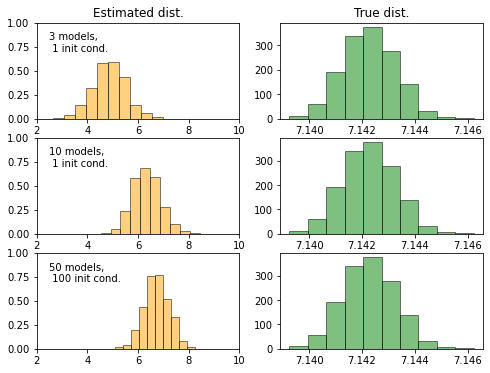

In [442]:
# plot a normal distribution with the conditional mean and variance
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab
import math
conditional_mu1, conditional_sigma1 = calc_cond_dist(100, 20, 50)
A1 = np.random.normal(conditional_mu1, conditional_sigma1, (1000, 1))
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8, 6))
conditional_mu, conditional_sigma = calc_cond_dist(1, 3, 1)
A = np.random.normal(conditional_mu, conditional_sigma, (1000, 1))
num_bins = 10
# the histogram of the data
ax[0, 0].hist(A, num_bins, density=True, facecolor='orange', alpha=0.5, edgecolor='black')
ax[0, 0].text(2.5, 0.7, "3 models, \n 1 init cond.")
# ax[0].legend()
ax[0, 0].set_title('Estimated dist.')
ax[0, 1].hist(A1, num_bins, density=True, facecolor='green', alpha=0.5, edgecolor='black')
# ax[1].legend()
ax[0, 1].set_title('True dist.')
conditional_mu, conditional_sigma = calc_cond_dist(1, 10, 1)
ax[1, 0].hist(np.random.normal(conditional_mu, conditional_sigma, (1000, 1)), num_bins, density=True, facecolor='orange', alpha=0.5, edgecolor='black')
ax[1, 0].text(2.5, 0.7, "10 models, \n 1 init cond.")
# ax[2].legend()
ax[1, 1].hist(A1, num_bins, density=True, facecolor='green', alpha=0.5, edgecolor='black')
# ax[1].legend()
# ax[1, 1].set_title('True dist.')
conditional_mu, conditional_sigma = calc_cond_dist(1, 50, 100)
ax[2, 0].hist(np.random.normal(conditional_mu, conditional_sigma, (1000, 1)), num_bins, density=True, facecolor='orange', alpha=0.5, edgecolor='black')
ax[2, 0].text(2.5, 0.7, "50 models, \n 100 init cond.")
# ax[2].legend()
ax[2, 1].hist(A1, num_bins, density=True, facecolor='green', alpha=0.5, edgecolor='black')
# ax[2].legend()
# Set global x-axis range
global_xmin = 2
global_xmax = 10
global_ymin = 0
global_ymax = 1
for row in range(ax.shape[0]):  # Iterate over rows
    ax[row][0].set_xlim(global_xmin, global_xmax)  # Apply to subplot in column 0
    ax[row][0].set_ylim(global_ymin, global_ymax)  # Apply to subplot in column 1

plt.show()

In [502]:
Z = np.random.multivariate_normal([0, 0], [[5, 0], [0, 0.5]], 1000)

In [503]:
Z.shape

(1000, 2)

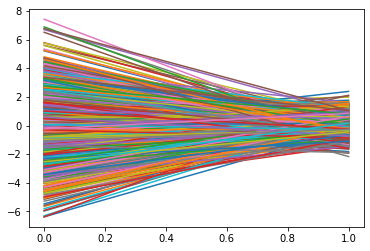

In [504]:
for i in range(1000):
    plt.plot(np.arange(0, 2), Z[i, :])
plt.show()


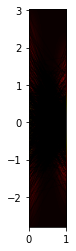

In [500]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Assuming Z is your 2D array of shape (1000, 2)
x = np.linspace(0, 1, 2)  # Fixed x range
y = Z.flatten()  # Flatten Z to use in KDE

# Create meshgrid for the heatmap
xx, yy = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

# Gaussian KDE for density estimation
kernel = gaussian_kde(np.vstack([np.tile(x, Z.shape[0]), y]))
f = np.reshape(kernel(positions).T, xx.shape)

# Plot the heatmap
plt.imshow(np.rot90(f), cmap='hot', extent=[x.min(), x.max(), y.min(), y.max()])

# Overlay the original lines
for i in range(1000):
    plt.plot(x, Z[i, :], 'k', linewidth=0.5, alpha=0.5)  # 'k' for black lines, adjust alpha for visibility

plt.xlim([0, 1])
plt.ylim([y.min(), y.max()])
plt.show()


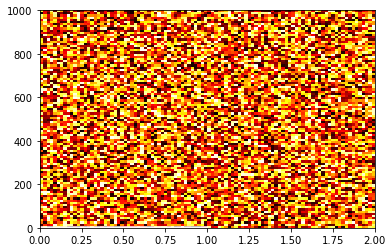

In [501]:
import numpy as np
import matplotlib.pyplot as plt

# Example density data (replace with your actual density calculation)
density = np.random.rand(100,100) # This should be replaced with your calculated densities

# Create the heatmap
plt.imshow(density, cmap='hot', interpolation='nearest', extent=[0, 2, 0, 1000], aspect='auto')

# Overlay the original lines (example lines)
Z = np.random.rand(1000, 2)  # Your original line data
for i in range(1000):
    plt.plot(np.arange(0, 2), Z[i, :], 'w-', alpha=0.1)  # 'w-' for white lines, adjust alpha for visibility

plt.show()


In [ ]:
for row in range(num_obs + sum(num_per_model)):
    for col in range(num_obs + sum(num_per_model)):
        if row == 0 and col == 0: # obs with obs
            cov_matrix[row, col] = 2.5 + 1
        elif row == 0 and (col > 0) and (col <= 1 + sum()): # obs with model 1
            cov_matrix[row, col] = 2.5
        elif row == 0 and (col > 1 + num_per_model_1) and (col <= 1 + num_per_model_1 + num_per_model_2): # obs with model 2
            cov_matrix[row, col] = 2.5
        elif (row > 0) and (row <= 1 + num_per_model_1) and col == 0: # model 1 with obs
            cov_matrix[row, col] = 2.5
        elif (row > 0) and (row <= 1 + num_per_model_1) and (col > 0) and (col <= 1 + num_per_model_1): # model 1 with model 1
            if row == col: # same init condition
                cov_matrix[row, col] = 2.5 + sigma[0] + sigma_k2[0]
            else: # diff init condition
                cov_matrix[row, col] = 2.5 + sigma[0]
        elif (row > 0) and (row <= 1 + num_per_model_1) and (col > 0) and (col > 1 + num_per_model_1):  # model 1 with model 2 
            cov_matrix[row, col] = 2.5
        elif (row > 1 + num_per_model_1) and (row <= 1 + num_per_model_1 + num_per_model_2) and col == 0: # model 2 with obs
            cov_matrix[row, col] = 2.5
        elif (row > 1 + num_per_model_1) and (row <= 1 + num_per_model_1 + num_per_model_2) and (col > 0) and (col <= 1 + num_per_model_1): # model 2 with model 1
            cov_matrix[row, col] = 2.5
        elif (row > 1 + num_per_model_1) and (row <= 1 + num_per_model_1 + num_per_model_2) and (col > 0) and (col > 1 + num_per_model_1):  # model 2 with model 2
            if row == col: # same init condition
                cov_matrix[row, col] = 2.5 + sigma[0] + sigma_k2[1]
            else: # diff init condition
                cov_matrix[row, col] = 2.5 + sigma[0]
        else:
            raise ValueError("row or col not in range")
        


In [ ]:
# When would the ensemble spread be equal to the long term variability? 
#This means that there is some dist. at each time step 
#Var(Y_t)
#When would the VAR(Y_t) be equal. Only when 
#Y_1, Y_2, .. are independent and iid. Then 
# VAR(Y_t) = \sigma^2
# \sigma^2  = 1/N \sum_{i=1}^{N} (Y_t_i - \bar{Y_t})^2
# but we can replace Y_t_i with Y_x for any x.
# and replace \bar{Y_t} with \bar{Y}.